# Visualization of the Ngrammatic benchmarks

In [1]:
from matplotlib import pyplot as plt

In [41]:
import pandas as pd

def determine_data_structure(bench_name: str) -> str:
    if "webgraph" in bench_name:
        return "WebGraph"

    if "bitvec" in bench_name:
        return "BitVec"

    if "old" in bench_name or "hashmap" in bench_name:
        return "HashMap"
    
    return "Vec"

def determine_text_structure(bench_name: str) -> str:
    if "rcl" in bench_name:
        return "RCL"
    
    return "Vec"

def determine_search_type(bench_name: str) -> str:
    if "tfidf" in bench_name:
        return "TF-IDF Ngram"

    if "build_corpus" in bench_name:
        return "Build Corpus"

    return "Ngram"

def determine_parallelism(bench_name: str) -> str:
    if "par" in bench_name:
        return "Parallel"

    return "Sequential"

def load_log(filename: str) -> pd.DataFrame:
    """Load the performance log.

    Parameters
    ----------
    filename : str
        The filename of the log.

    Implementative details
    ----------------------
    We are loading a cargo bench log file, which looks
    like the following plain text lines:

    ```plaintext
    test bigram_bitvec_seq_search_rcl      ... bench:  25,202,226.20 ns/iter (+/- 49,712.83)
    test bigram_bitvec_seq_search_vec      ... bench:  25,284,997.20 ns/iter (+/- 55,285.99)
    ```
    """
    arity = {
        "monogram": 1,
        "bigram": 2,
        "trigram": 3,
        "tetragram": 4,
        "pentagram": 5,
        "hexagram": 6,
        "heptagram": 7,
        "octagram": 8,
    }
    rows = []
    with open(filename, "r", encoding="utf8") as f:
        lines = f.readlines()
        # We skip the first line, as it only
        # provides the number of benchmarks.
        for line in lines[1:]:
            line = line.strip()
            if "bench" not in line:
                continue
            bench_name, mean, std = [
                element
                for element in line.split(" ")
                if len(element) > 0 and element not in ["test", "...", "bench:", "ns/iter", "(+/-"]
            ]
            std = std.strip(")")
            arity_name, *rest = bench_name.split("_")
            arity_value = arity[arity_name]
            data_structure = determine_data_structure(bench_name)
            text_structure = determine_text_structure(bench_name)
            rows.append({
                "arity": arity_value,
                "data_structure": data_structure,
                "text_structure": text_structure,
                "combined_structure": f"{data_structure} + {text_structure}",
                "search_type": determine_search_type(bench_name),
                "parallelism": determine_parallelism(bench_name),
                "mean": float(mean.replace(",", "")),
                "std": float(std.replace(",", "")),
            })

    return pd.DataFrame(rows)

In [39]:
df = load_log("search_perf.log")
df

,arity,data_structure,text_structure,combined_structure,search_type,parallelism,mean,std
0,2,BitVec,RCL,BitVec + RCL,Ngram,Parallel,16177541.1,2089176.93
1,2,BitVec,Vec,BitVec + Vec,Ngram,Parallel,16461056.3,1654920.29
2,2,BitVec,RCL,BitVec + RCL,Ngram,Sequential,25202226.2,49712.83
3,2,BitVec,Vec,BitVec + Vec,Ngram,Sequential,25284997.2,55285.99
4,2,HashMap,Vec,HashMap + Vec,Ngram,Sequential,187156611.9,1797520.97
...,...,...,...,...,...,...,...,...
195,3,Vec,Vec,Vec + Vec,Ngram,Sequential,15527970.8,1131474.68
196,3,WebGraph,RCL,WebGraph + RCL,Ngram,Parallel,73489307.0,11495071.41
197,3,WebGraph,Vec,WebGraph + Vec,Ngram,Parallel,71785497.0,9301869.23
198,3,WebGraph,RCL,WebGraph + RCL,Ngram,Sequential,115822625.9,2291520.69


We proceed to plot the results of the Ngrammatic benchmarks, showing on the axis of the abscissas the number of n-grams and on the axis of the ordinates the time taken to compute the n-grams, with an area plot to illustrate the standard deviation of the time taken to execute the search.

We split the results into two plots, one for the `Ngram` search (left) and the other for the `TF-IDF Ngram` search (right).

We distinguish the sequential search from the parallel search by using dashing lines for the sequential search and solid lines for the parallel search.

For any givem combined structure, we always use the same color, no matter whether the run is sequential or parallel.

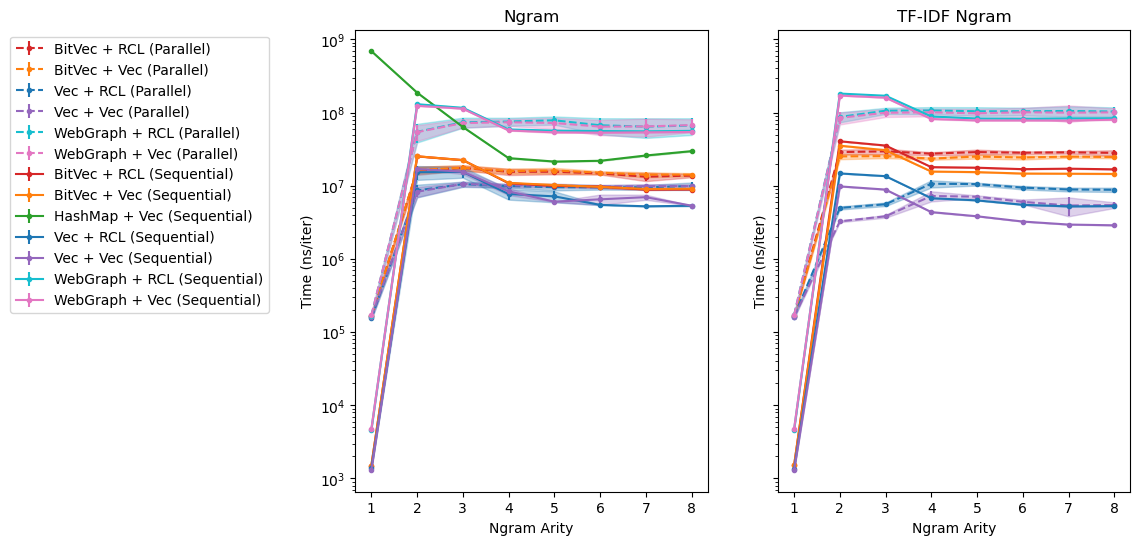

In [37]:
colors = {
    'BitVec + RCL': "tab:red",
    'BitVec + Vec': "tab:orange",
    'HashMap + Vec': "tab:green",
    'Vec + RCL': "tab:blue",
    'Vec + Vec': "tab:purple",
    'WebGraph + RCL': "tab:cyan",
    'WebGraph + Vec': "tab:pink",
}

fig, ax = plt.subplots(figsize=(10, 6), ncols=2, sharey=True)

for i, (search_type, group) in enumerate(df.groupby("search_type")):
    for j, (parallelism, sub_group) in enumerate(group.groupby("parallelism")):
        for k, (combined_structure, sub_sub_group) in enumerate(sub_group.groupby("combined_structure")):
            sub_sub_group = sub_sub_group.sort_values("arity")
            ax[i].fill_between(
                sub_sub_group["arity"],
                sub_sub_group["mean"] - sub_sub_group["std"],
                sub_sub_group["mean"] + sub_sub_group["std"],
                color=colors[combined_structure],
                alpha=0.3,
            )
            ax[i].errorbar(
                sub_sub_group["arity"],
                sub_sub_group["mean"],
                yerr=sub_sub_group["std"],
                label=f"{combined_structure} ({parallelism})",
                color=colors[combined_structure],
                marker=".",
                linestyle="-" if parallelism == "Sequential" else "--",
            )
        ax[i].set_yscale("log")
        ax[i].set_title(search_type)
        ax[i].set_xlabel("Ngram Arity")
        ax[i].set_ylabel("Time (ns/iter)")
    if i == 0:
        # We make the font of the legend smaller to fit
        # two columns side by side. Furthermore, we position
        # the legend outside of the plot.
        ax[i].legend(loc="upper left", bbox_to_anchor=(-1, 1))

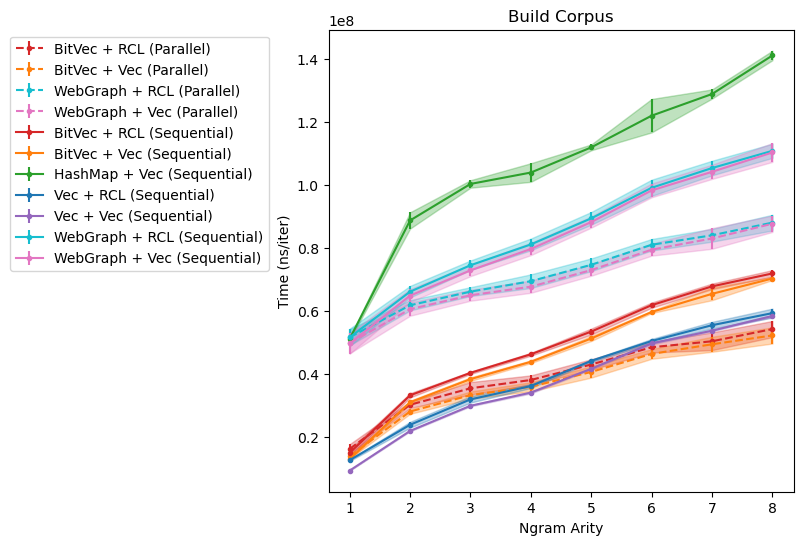

In [52]:
df = load_log("build_corpus_perf.log")
fig, ax = plt.subplots(figsize=(6, 6))

for i, (parallelism, group) in enumerate(df.groupby("parallelism")):
    for j, (combined_structure, sub_group) in enumerate(group.groupby("combined_structure")):
        sub_group = sub_group.sort_values("arity")
        ax.fill_between(
            sub_group["arity"],
            sub_group["mean"] - sub_group["std"],
            sub_group["mean"] + sub_group["std"],
            color=colors[combined_structure],
            alpha=0.3,
        )
        ax.errorbar(
            sub_group["arity"],
            sub_group["mean"],
            yerr=sub_group["std"],
            label=f"{combined_structure} ({parallelism})",
            color=colors[combined_structure],
            marker=".",
            linestyle="-" if parallelism == "Sequential" else "--",
        )
    ax.set_title("Build Corpus")
    ax.set_xlabel("Ngram Arity")
    ax.set_ylabel("Time (ns/iter)")
    ax.legend(loc="upper left", bbox_to_anchor=(-0.7, 1))